In [2]:
# !pip install resemblyzer

^C


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
# 导入 Resemblyzer 模块
from resemblyzer import VoiceEncoder, preprocess_wav
from sklearn.decomposition import PCA
from tqdm import tqdm

In [13]:
# 初始化 Resemblyzer 说话人编码器
encoder = VoiceEncoder()

# 读取 meta.csv，该文件包含文件名、speaker 以及 label 信息
meta = pd.read_csv("../Data/itw_meta.csv")

Loaded the voice encoder model on cpu in 0.02 seconds.


In [14]:
# 初始化存储列表
embeddings_list = []  # 存储每个音频的嵌入
file_names = []  # 存储文件名（方便后续调试或进一步操作）
speakers = []  # 存储每个音频对应的 speaker
labels = []  # 存储每个音频对应的 label

In [26]:
# 使用 value_counts 并归一化后得到各 speaker 的占比
speaker_counts = meta['speaker'].value_counts(normalize=True)
print("所有 speaker 的占比：")
print(speaker_counts)

# 计算唯一 speaker 数量
num_speakers = len(speaker_counts)

# 由于 value_counts 默认按照降序排列，
# 后半部分即为出现频率较低的那 50% speaker
selected_speakers = set(speaker_counts.iloc[:num_speakers // 5].index)
print("按占比排序后后50%的 speaker:", selected_speakers)

所有 speaker 的占比：
speaker
Barack Obama                0.114415
Alec Guinness               0.114069
Donald Trump                0.107713
Bernie Sanders              0.090531
Ayn Rand                    0.078448
Bill Clinton                0.057648
Ronald Reagan               0.048334
Christopher Hitchens        0.042135
Winston Churchill           0.027754
Martin Luther King          0.025142
JFK                         0.021052
Milton Friedman             0.018534
Mark Zuckerberg             0.018314
FDR                         0.014821
Queen Elizabeth II          0.014601
Louis Farrakhan             0.012902
Alexandria Ocasio-Cortez    0.012272
Nelson Mandela              0.011989
Alan Watts                  0.011895
Richard Nixon               0.011297
Arnold Schwarzenegger       0.011045
The Notorious B.I.G.        0.010353
Boris Johnson               0.009283
Dwight Eisenhower           0.008433
George Carlin               0.007804
George W. Bush              0.007237
Adam Driver   

In [27]:
# 文件所在的目录，这里文件路径格式为 "release_in_the_wild/0.wav"
audio_dir = "../Data/inthewild/release_in_the_wild"

import concurrent.futures


# 定义处理单个行数据的函数
def process_row(index_row):
    index, row = index_row
    file_name = row['file']  # 如 "0.wav"
    speaker = row['speaker']
    label = row['label']

    # 此处可根据需要过滤数据，例如只处理选中的 speaker 并且 label 为 "bona-fide"
    if speaker not in selected_speakers or label != "bona-fide":
        return None

    # 构造完整音频文件路径
    file_path = os.path.join(audio_dir, file_name)

    try:
        # 加载音频文件，preprocess_wav 会对文件进行必要的预处理
        wav = preprocess_wav(file_path)
        # 获取该音频文件的说话人嵌入
        embedding = encoder.embed_utterance(wav)
        return (embedding, file_name, speaker, label)
    except Exception as e:
        print(f"加载 {file_path} 时出错: {e}")
        return None


# 使用 ThreadPoolExecutor 进行多线程处理
# 可以根据机器配置调整 max_workers 的数量，这里设定为 8 个线程作为示例
results = []
with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
    # meta.iterrows() 生成 (index, row) 的元组，传入 process_row
    # tqdm 包裹 executor.map 来显示总处理进度
    for res in tqdm(executor.map(process_row, meta.iterrows()), total=len(meta)):
        if res is not None:
            results.append(res)

# 将结果拆分为各个列表
if results:
    embeddings_list, file_names, speakers, labels = zip(*results)
    # 转换成列表（如果需要后续处理修改为列表）
    embeddings_list = list(embeddings_list)
    file_names = list(file_names)
    speakers = list(speakers)
    labels = list(labels)
else:
    embeddings_list, file_names, speakers, labels = [], [], [], []



100%|██████████| 31779/31779 [02:31<00:00, 209.25it/s]


15177it [02:09, 117.07it/s]


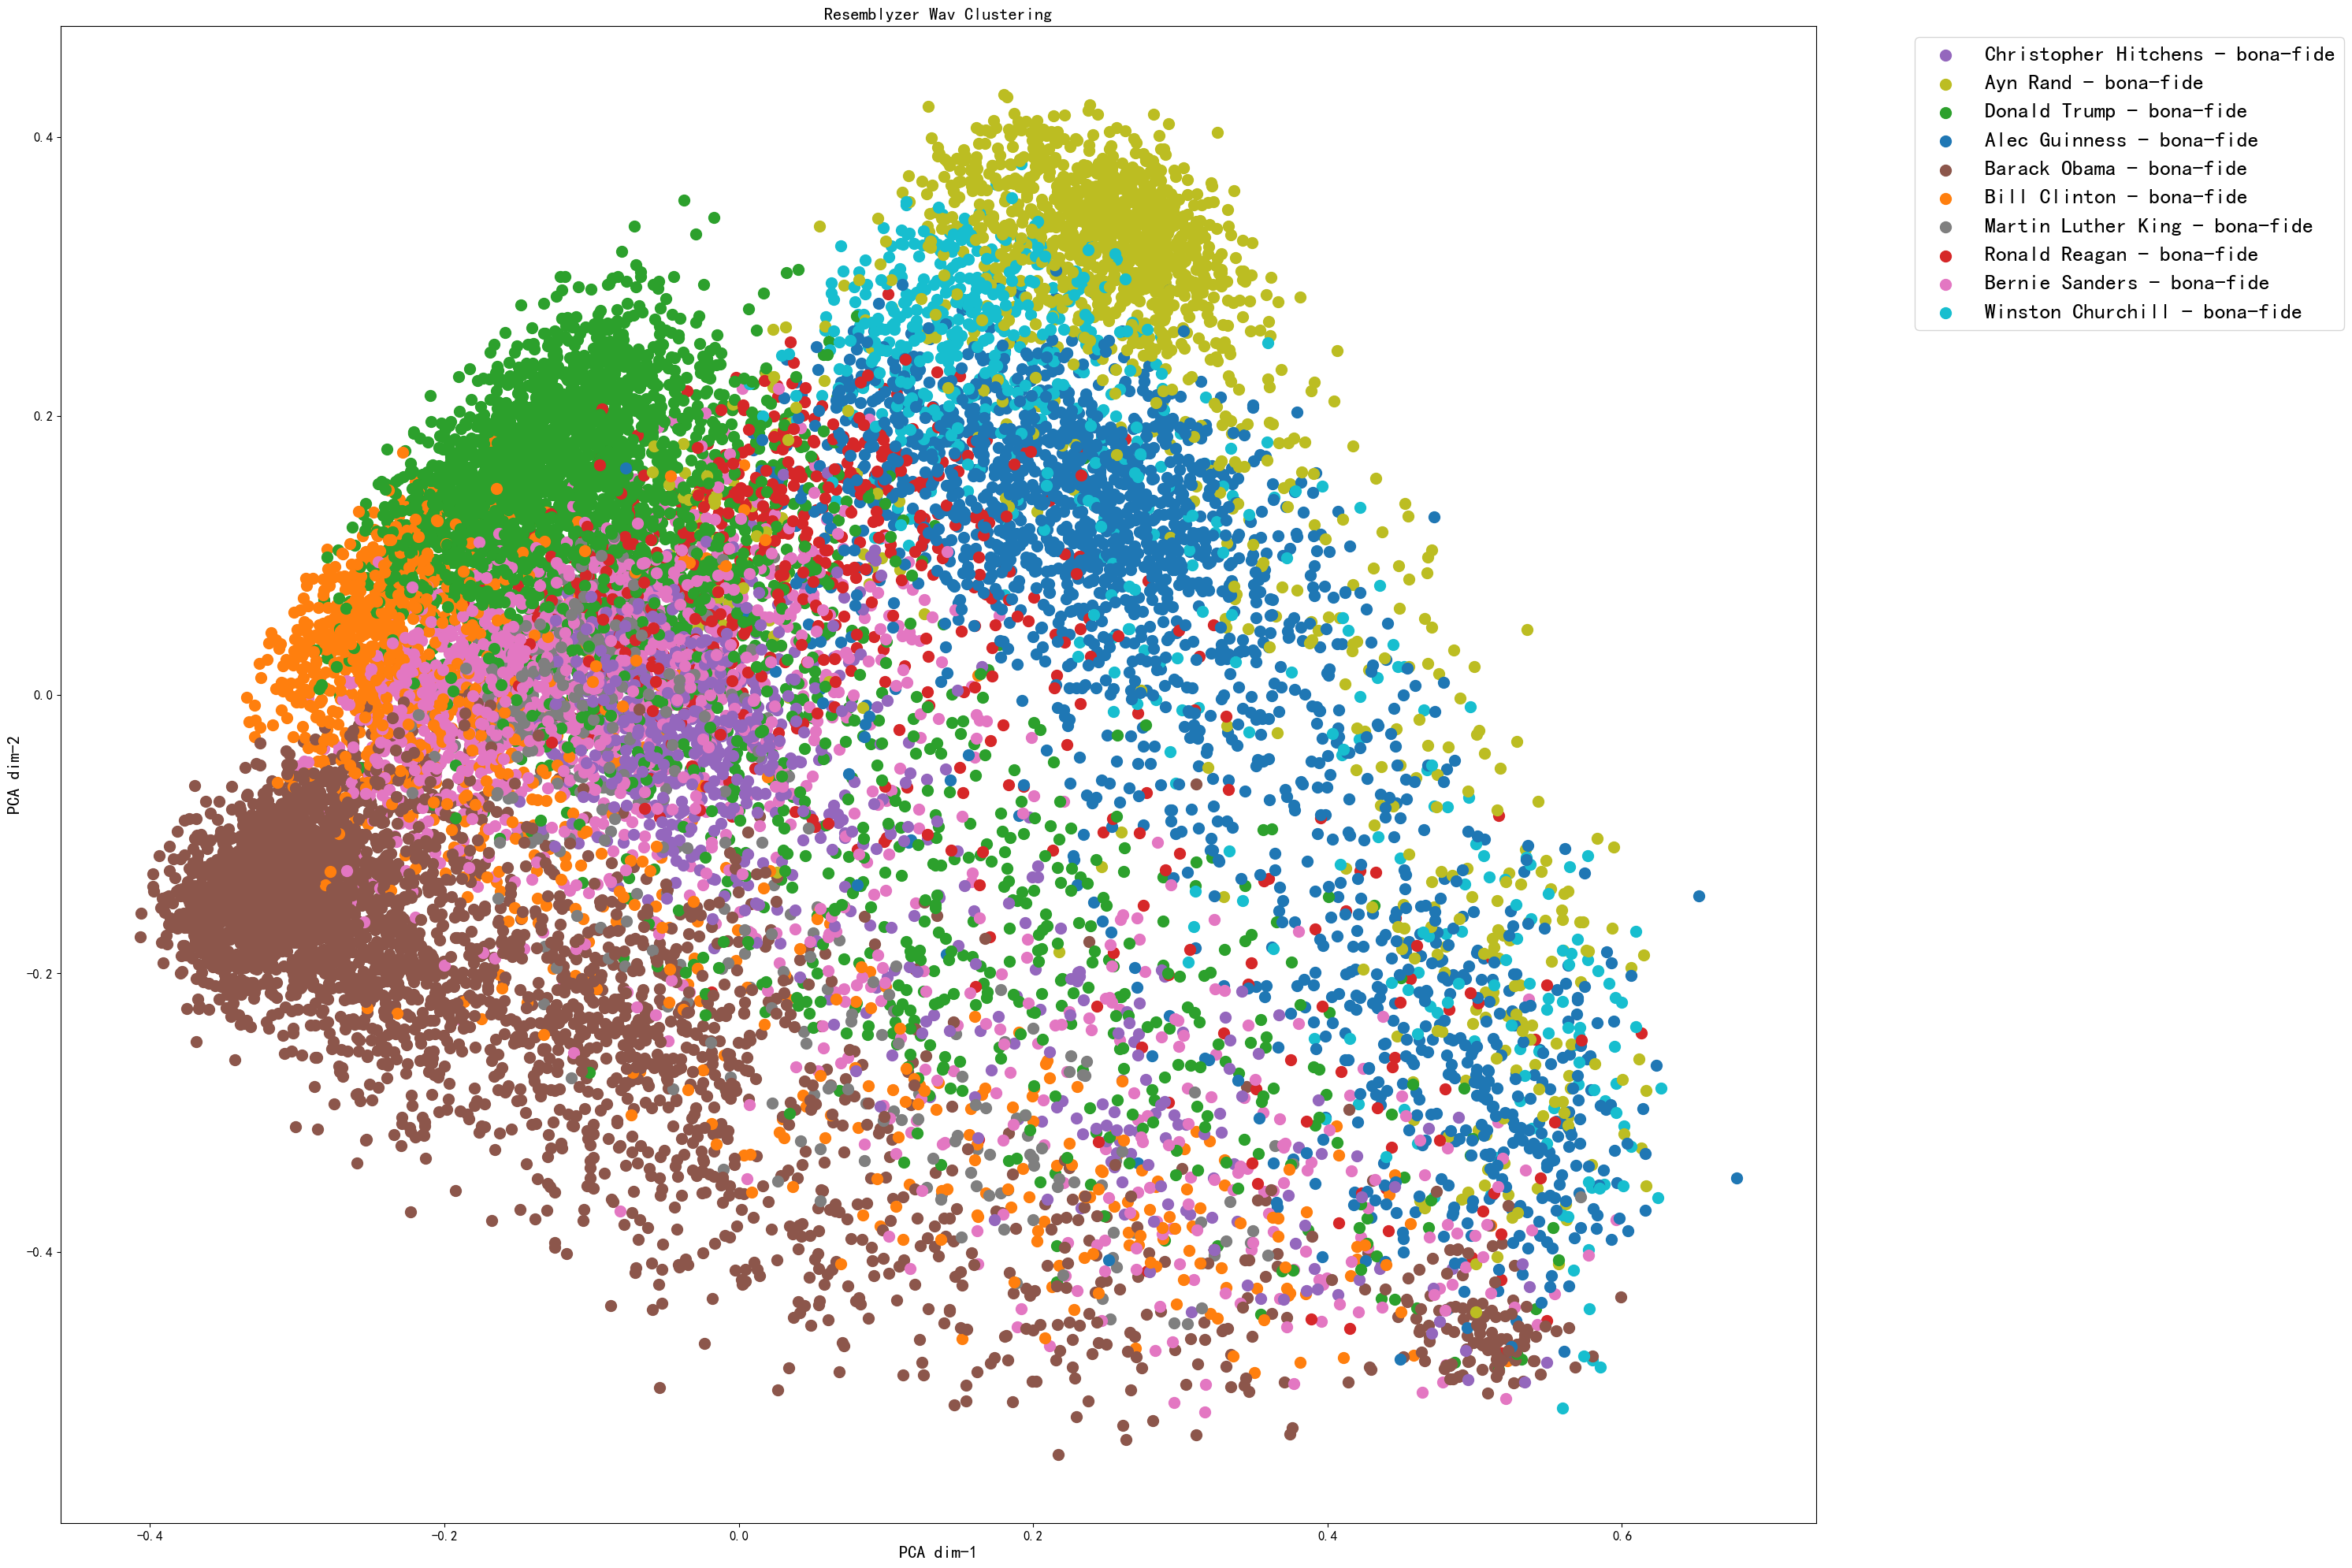

In [30]:
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为 SimHei（黑体）
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示为方块的问题

# 将嵌入列表转换为 numpy 数组
embeddings_array = np.array(embeddings_list)

# 使用 PCA 将高维嵌入降到二维
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# 可视化：使用 matplotlib 绘制散点图
plt.figure(figsize=(30, 20))

# 为不同的 speaker 分配颜色
unique_speakers = list(set(speakers))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_speakers)))
speaker_color_map = {sp: col for sp, col in zip(unique_speakers, colors)}

# 定义 label 对应的标记形状
marker_map = {"bona-fide": "o", "spoof": "s"}

# 为了图例去重，记录已添加的 legend label
added_labels = set()

for i, (x, y_val) in tqdm(enumerate(embeddings_2d)):
    current_speaker = speakers[i]
    current_label = labels[i]
    # 根据 speaker 选择颜色、根据 label 选择标记形状
    color = speaker_color_map[current_speaker]
    marker = marker_map.get(current_label, "o")

    # 构建单个数据点的 label，用于图例标注，确保每个 (speaker, label) 组合只显示一次
    legend_label = f"{current_speaker} - {current_label}"
    if legend_label not in added_labels:
        plt.scatter(x, y_val, color=color, marker=marker, s=100, label=legend_label)
        added_labels.add(legend_label)
    else:
        plt.scatter(x, y_val, color=color, marker=marker, s=100)

plt.title("Resemblyzer Wav Clustering", fontsize=16)
plt.xlabel("PCA dim-1", fontsize=16)
plt.ylabel("PCA dim-2", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1),
           loc="upper left",
           fontsize=20)
plt.tight_layout()
plt.show()

100%|██████████| 15177/15177 [02:06<00:00, 119.72it/s]


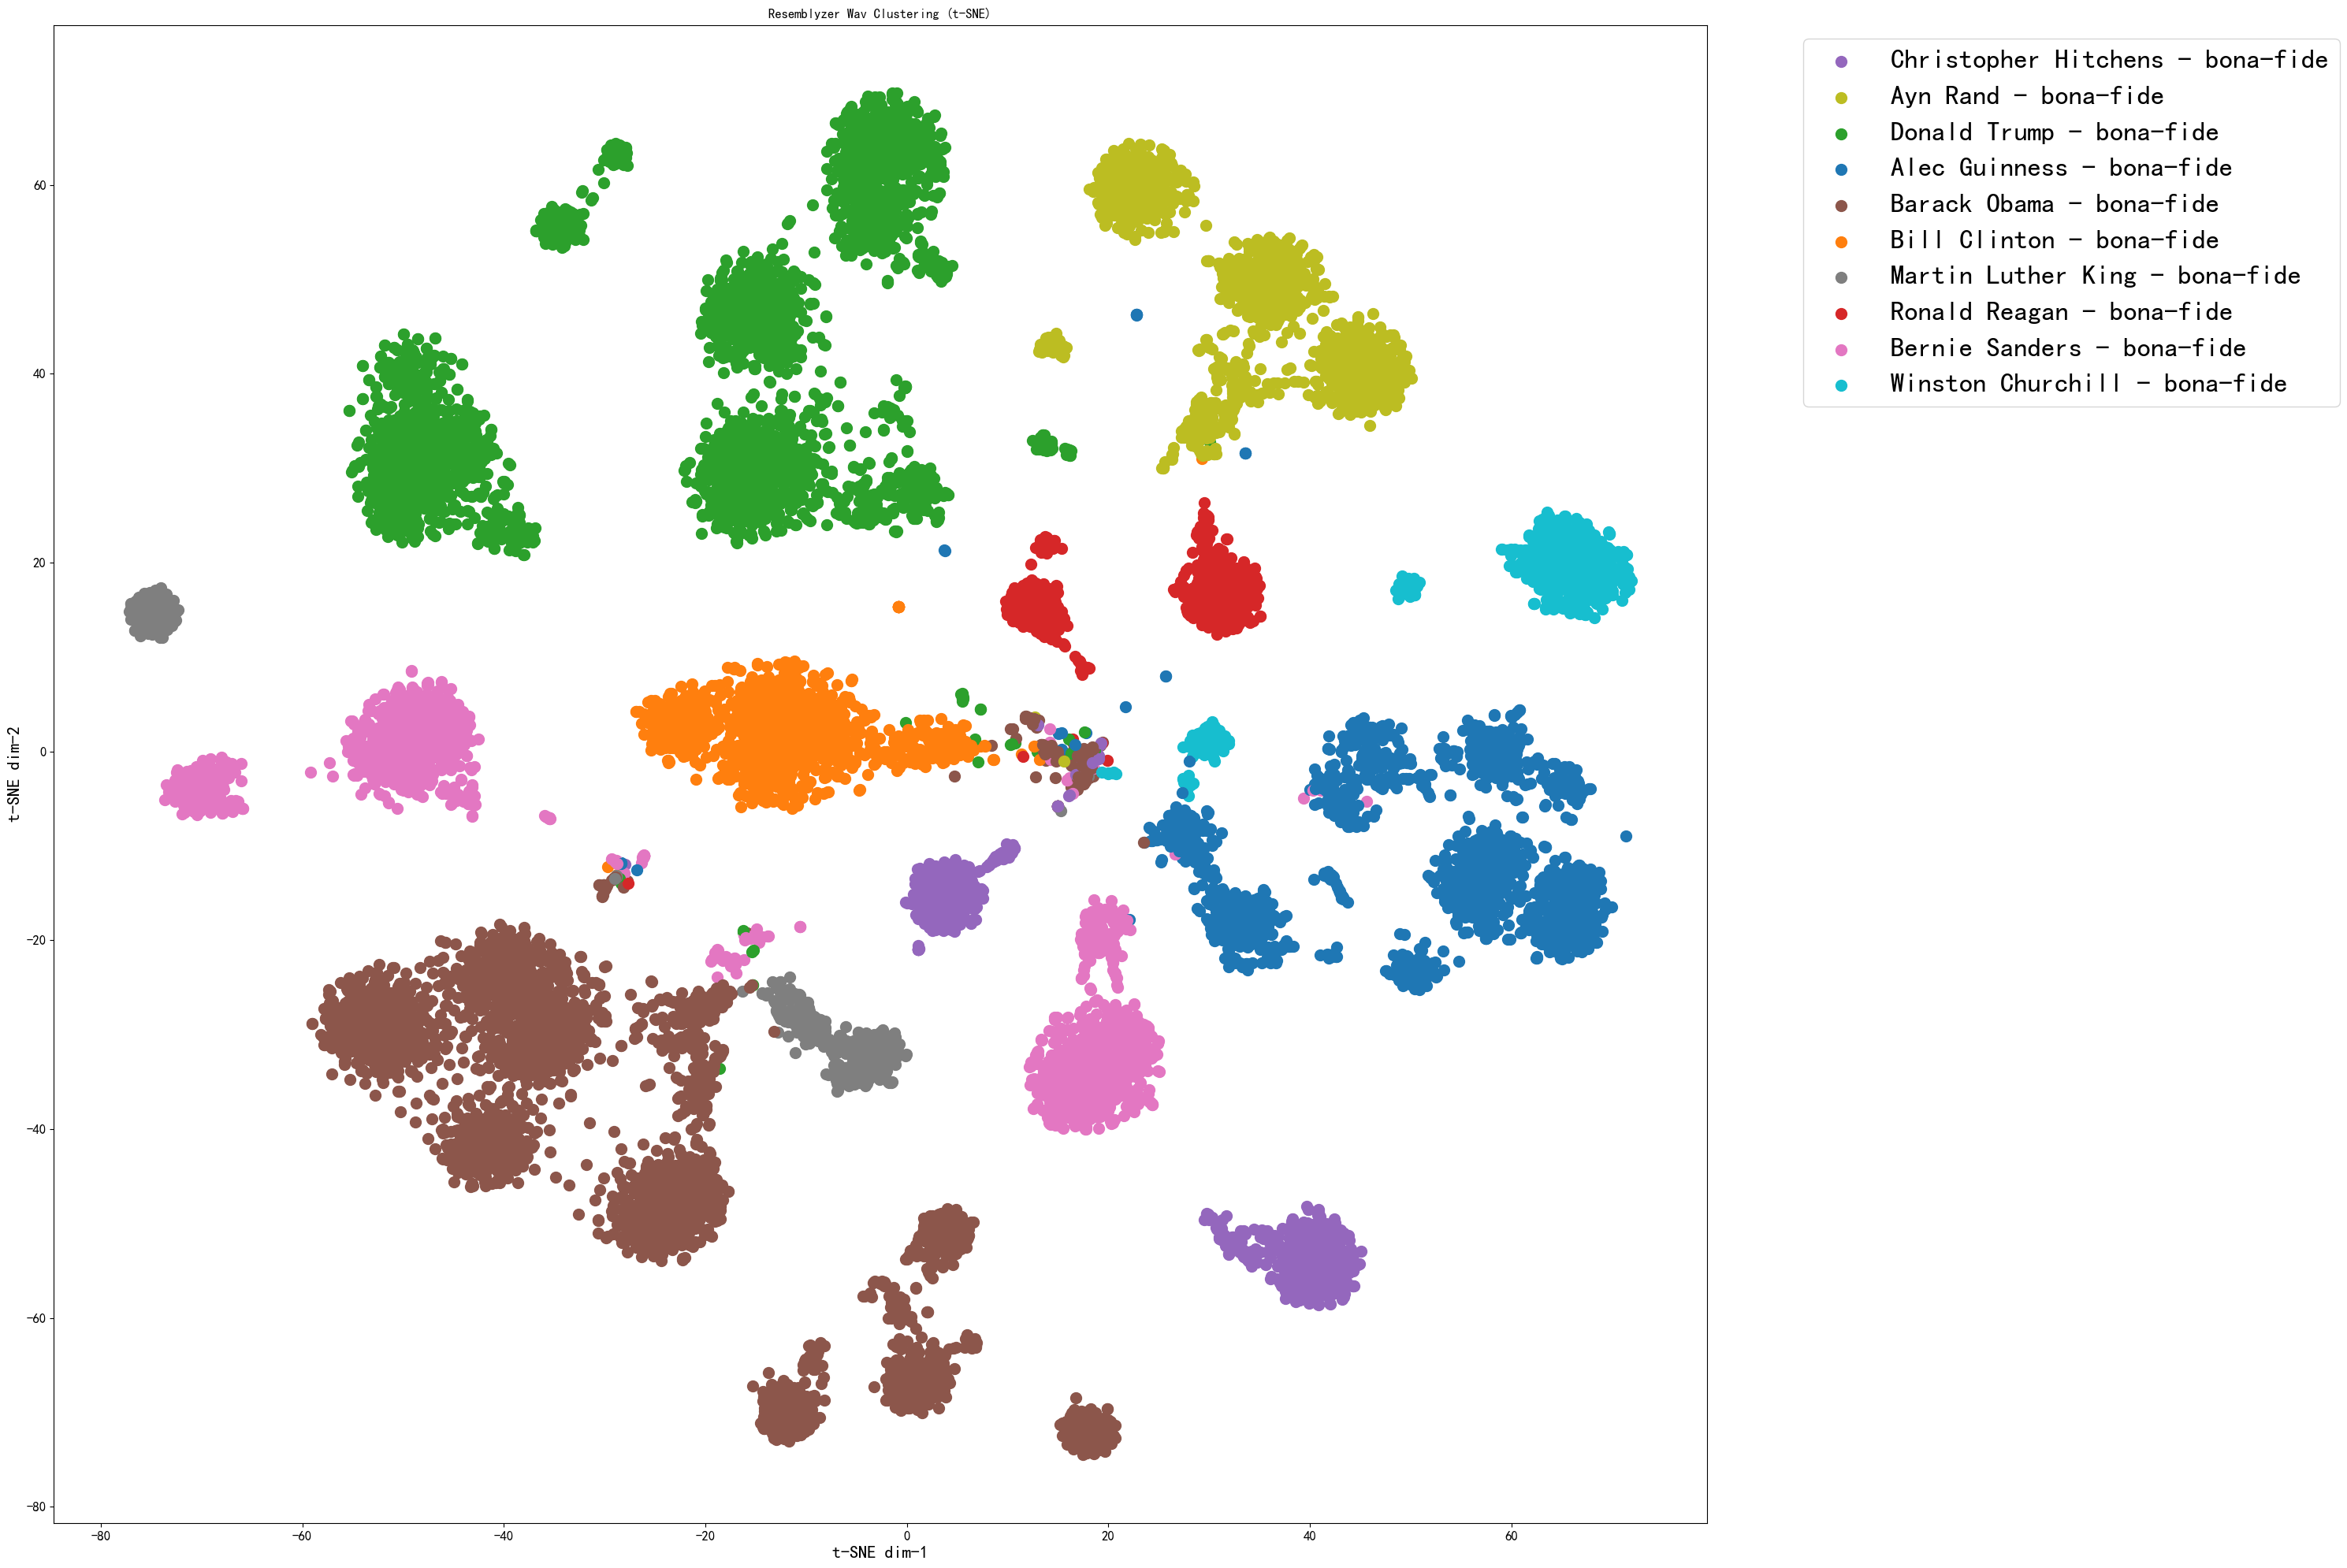

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# 设置中文字体支持（如果需要显示中文）
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

# 假设 embeddings_list、speakers 和 labels 已经存在
# 将嵌入列表转换为 NumPy 数组
embeddings_array = np.array(embeddings_list)

# 使用 t-SNE 将高维嵌入降到二维
tsne = TSNE(n_components=2, random_state=30)
embeddings_2d = tsne.fit_transform(embeddings_array)

# 绘图：使用 matplotlib 绘制散点图
plt.figure(figsize=(30, 20))

# 为不同的 speaker 分配颜色
unique_speakers = list(set(speakers))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_speakers)))
speaker_color_map = {sp: col for sp, col in zip(unique_speakers, colors)}

# 定义 label 对应的标记形状（例如 bona-fide 用圆点，spoof 用正方形）
marker_map = {"bona-fide": "o", "spoof": "s"}

# 为了图例中每个 speaker-label 组合只出现一次，用集合记录已添加的图例标签
added_labels = set()

for i, (x, y_val) in tqdm(enumerate(embeddings_2d), total=len(embeddings_2d)):
    current_speaker = speakers[i]
    current_label = labels[i]
    color = speaker_color_map[current_speaker]
    marker = marker_map.get(current_label, "o")
    legend_label = f"{current_speaker} - {current_label}"
    if legend_label not in added_labels:
        plt.scatter(x, y_val, color=color, marker=marker, s=100, label=legend_label)
        added_labels.add(legend_label)
    else:
        plt.scatter(x, y_val, color=color, marker=marker, s=100)

plt.title("Resemblyzer Wav Clustering (t-SNE)")
plt.xlabel("t-SNE dim-1", fontsize=16)
plt.ylabel("t-SNE dim-2", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1),
           loc="upper left",
           fontsize=25)
plt.tight_layout()
plt.show()
